Rainbow-ification!
---

In this notebook, we'll quickly explore the effects of 'rain-bowification' of audio signals on model performance. We'll use the same model architecture, data and labels found in `efb_context_labeler.ipynb`. 

We will compute transforms of the vocalization samples and compare the convergence rate of the models that are fit to the transformed data: 

In [1]:
from fastai.vision.all import *
import torchaudio
import pathlib
from IPython.display import Audio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [2]:
dest_path = "/home/jupyter/data/"
path = Path("{}egyptian_fruit_bat_annotated_tiny".format(dest_path))
wav_files = [str(x) for x in path.glob("**/*") if "WAV" in str(x)]


print("Found {} squeaks!".format(len(wav_files)))
Audio(filename = wav_files[0])

Found 8224 squeaks!


In [3]:
annotations_full = pd.read_csv("{}/egyptian_fruit_bat_annotated_tiny/better_annotations.csv".format(dest_path))
context_dict = {0:"unknown", 1:"separation", 2:"biting", 
                3:"feeding", 4:"fighting", 5:"grooming", 
                6:"isolation", 7:"kissing", 8:"landing", 
                9:"mating protest", 10:"threat-like", 
                11:"general", 12:"sleeping"}

annotations = annotations_full.loc[:,["File name", "File folder", "Context"]]
annotations["Context desc."] = [context_dict[x] for x in annotations["Context"]]
annotations["File path"] = ["{}/{}/{}".format(str(path),
                                              str(annotations['File folder'][i]), 
                                              str(annotations['File name'][i])) for i in annotations.index]

annotations = annotations[annotations["File path"].isin(wav_files)]
annotations = annotations.drop_duplicates(subset = ['File path'])

annotations = annotations.loc[annotations['Context desc.'] != 'landing']
annotations = annotations.loc[annotations['Context desc.'] != 'unknown']
annotations = annotations.loc[annotations['Context desc.'] != 'general']

annotations = annotations.reset_index()

Below are the rainbow-ification functions we will be comparing against one another:

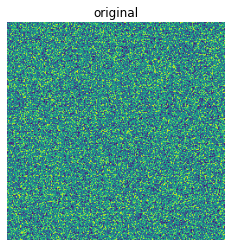

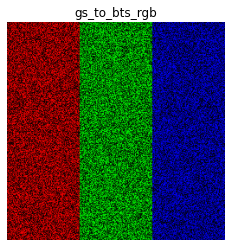

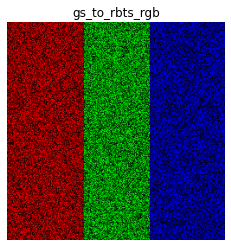

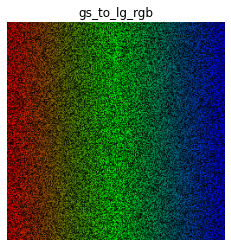

In [4]:
def gs_to_bts_rgb(x):
    #grey scale to block-time-segmented rgb
    one_block = np.ones((x.shape[0], int(x.shape[1]/3)))
    zero_block = np.zeros((x.shape[0], int(x.shape[1]/3)))
    
    mask0 = np.block([one_block, zero_block, zero_block])
    mask1 = np.block([zero_block, one_block, zero_block])
    mask2 = np.block([zero_block, zero_block, one_block])

    new_x = np.dstack((np.multiply(x, mask0),
                       np.multiply(x, mask1), 
                       np.multiply(x, mask2)))
    
    return new_x

def gs_to_rbts_rgb(x, variance = 0.08):
    #grey scale to random block-time-segmented rgb
    t = np.random.uniform(0.333 - variance, 0.333 + variance, 3)
    t = np.round(t/sum(t)*x.shape[1]).astype(np.uint8)
    t[2] -= sum(t) - x.shape[1] #correcting rounding error
    
    block_0 = (np.ones((x.shape[0], t[0]))).astype(np.bool)
    block_1 = (np.ones((x.shape[0], t[1]))).astype(np.bool)
    block_2 = (np.ones((x.shape[0], t[2]))).astype(np.bool)
    
    mask0 = np.block([block_0.astype(np.uint8), 
                      np.invert(block_1).astype(np.uint8), 
                      np.invert(block_2).astype(np.uint8)])
    
    mask1 = np.block([np.invert(block_0).astype(np.uint8),
                      block_1.astype(np.uint8),
                      np.invert(block_2).astype(np.uint8)])
    
    mask2 = np.block([np.invert(block_0).astype(np.uint8),
                      np.invert(block_1).astype(np.uint8),
                      block_2.astype(np.uint8)])
    
    new_x = np.dstack((np.multiply(x, mask0),
                       np.multiply(x, mask1), 
                       np.multiply(x, mask2)))
    
    return new_x

def gs_to_lg_rgb(x):
    #grey scale to linear gradient rgb
    r, g, b = np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])
    
    def l(t, x0 = r, x1 = g, x2 = b):
        if abs(t) <= 0.5:
            return 2*t*x1 - 2*(t-0.5)*x0
        if (t > 0.5) and (t <= 1):
            return 2*(t-0.5)*x2 +-2*(t-1)*x1
        
    row_vals =np.array([l(t) for t in np.linspace(0, 1, x.shape[0])])
    mask = np.array([row_vals for _ in range(x.shape[1])])
    
    new_x = np.dstack((np.multiply(x, mask[:, :, 0]),
                       np.multiply(x, mask[:, :, 1]), 
                       np.multiply(x, mask[:, :, 2])))
    
    return new_x.reshape(x.shape[0], x.shape[1], 3)

test_im = np.random.rand(252, 252)
plt.title("original")
plt.imshow(test_im)
plt.axis("off")
plt.show()

plt.title("gs_to_bts_rgb")
plt.imshow(gs_to_bts_rgb(test_im))
plt.axis("off")
plt.show()

plt.title("gs_to_rbts_rgb")
plt.imshow(gs_to_rbts_rgb(test_im))
plt.axis("off")
plt.show()

plt.title("gs_to_lg_rgb")
plt.imshow(gs_to_lg_rgb(test_im))
plt.axis("off")
plt.show()

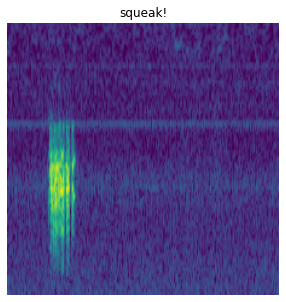

In [5]:
from skimage.transform import resize

def get_cqt(path, 
            final_transform = lambda x: x, 
            hop_length = 1024,
            n_bins = 90, 
            fmin = "C5"):
    
    x, rate = librosa.load(path, 
                           mono = True,
                           sr = None,
                           dtype = np.float32)

    spec = librosa.cqt(x,
                       sr = rate, 
                       fmin = librosa.note_to_hz(fmin),
                       hop_length=hop_length,
                       n_bins = n_bins)
    
    
    spec = librosa.amplitude_to_db(np.abs(spec), ref = np.max)
    spec = resize(spec, (225, 225))
    
    spec = 255*(spec - np.min(spec))/(np.max(spec) - np.min(spec))
    
    spec = final_transform(spec)
    return spec.astype(np.uint8)


x = get_cqt(wav_files[0])
plt.figure(figsize = (5, 5))
plt.imshow(x)
plt.title("squeak!")
plt.axis("off")
plt.show()

In [6]:
def get_y(p, annotations = annotations):
    return annotations.loc[annotations['File path'] == p]['Context desc.'].values[0]


# with get_items we want to make sure we have both the file and the label:
def get_items(p, annotations = annotations):
    temp_wav_files = [str(x) for x in get_files(p) if "WAV" in str(x)] 
    return annotations.loc[annotations['File path'].isin(temp_wav_files)]['File path'].values

We'll now construct the four `get_x` functions with the appropriate presets, one for each of the rainbow transforms above:

In [7]:
from functools import partial

I_get_x = get_cqt #I for identity
B_get_x = partial(get_cqt, final_transform = gs_to_bts_rgb) #B for block
RB_get_x = partial(get_cqt, final_transform = gs_to_rbts_rgb) #RB for random block
LG_get_x = partial(get_cqt, final_transform = gs_to_lg_rgb) #LG for linear gradient

Now prepping the dataloaders for each transformed dataset (might take a minute or two):

In [8]:
valid_idxs = annotations.sample(frac = 0.25, 
                                replace = False).index.values
valid_idxs

array([4948, 5333, 3653, ..., 4314, 3359, 2934])

In [9]:
I_dls = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                  get_items = get_items, 
                  get_x = I_get_x, 
                  get_y = get_y, 
                  splitter = IndexSplitter(valid_idxs)).dataloaders(path, bs = 8)

B_dls = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                  get_items = get_items, 
                  get_x = B_get_x, 
                  get_y = get_y, 
                  splitter = IndexSplitter(valid_idxs)).dataloaders(path, bs = 8)

RB_dls = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                  get_items = get_items, 
                  get_x = RB_get_x, 
                  get_y = get_y, 
                  splitter = IndexSplitter(valid_idxs)).dataloaders(path, bs = 8)

LG_dls = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                  get_items = get_items, 
                  get_x = LG_get_x, 
                  get_y = get_y, 
                  splitter = IndexSplitter(valid_idxs)).dataloaders(path, bs = 8)

In [10]:
I_learner = cnn_learner(I_dls, 
                        resnet34, 
                        metrics=accuracy)

B_learner = cnn_learner(B_dls, 
                        resnet34, 
                        metrics=accuracy)

RB_learner = cnn_learner(RB_dls, 
                        resnet34, 
                        metrics=accuracy)

LG_learner = cnn_learner(LG_dls, 
                        resnet34, 
                        metrics=accuracy)

In [11]:
learners = [I_learner, B_learner, RB_learner, LG_learner]
learner_names = ["I_learner", "B_learner", "RB_learner", "LG_learner"]

for learner, name in zip(learners, learner_names):
    learner.fit_one_cycle(8, 0.002)
    learner.save("{}_resnet34_efb".format(name))

epoch,train_loss,valid_loss,accuracy,time
0,2.592101,1.985555,0.373810,18:05
1,1.943441,1.780498,0.418452,18:00
2,1.853065,1.547076,0.464286,18:04
3,1.499108,1.439823,0.504762,17:59
4,1.434494,1.360409,0.516667,18:04
5,1.280578,1.307584,0.532738,17:59
6,1.246114,1.294432,0.529762,17:56
7,1.134063,1.296552,0.536310,17:51


epoch,train_loss,valid_loss,accuracy,time
0,2.568668,1.986642,0.380952,17:55
1,2.026070,1.798588,0.388095,17:40
2,1.669723,1.555370,0.476786,17:36
3,1.535357,1.451082,0.498810,17:42
4,1.423943,1.366745,0.523214,17:43
5,1.344723,1.323720,0.534524,17:43
6,1.183650,1.289850,0.548810,17:52
7,1.160592,1.286690,0.547024,17:48


epoch,train_loss,valid_loss,accuracy,time
0,2.554188,1.963133,0.386310,17:50
1,2.042628,1.730726,0.402976,18:01
2,1.681310,1.559801,0.453571,18:02
3,1.582157,1.441166,0.504762,18:08
4,1.483731,1.348390,0.532738,18:10
5,1.330397,1.291993,0.550000,18:00
6,1.296426,1.273810,0.554167,18:07
7,1.178316,1.269956,0.561310,18:08


epoch,train_loss,valid_loss,accuracy,time
0,2.600590,1.831598,0.405357,18:13
1,1.989320,1.737199,0.424405,18:07
2,1.749787,1.512047,0.468452,17:50
3,1.515556,1.496662,0.489286,17:54
4,1.427494,1.359247,0.522619,17:55
5,1.341743,1.277204,0.548810,17:49
6,1.275374,1.269265,0.552381,17:39
7,1.112314,1.264001,0.560714,17:47


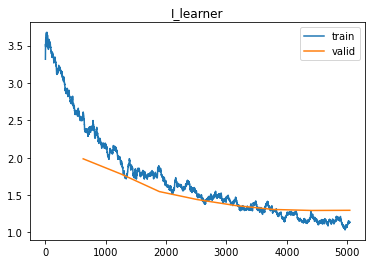

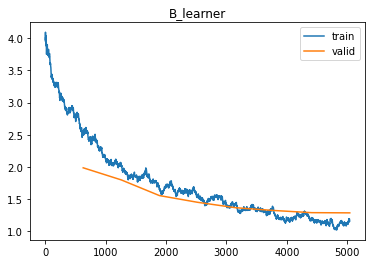

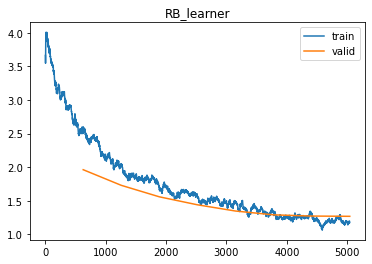

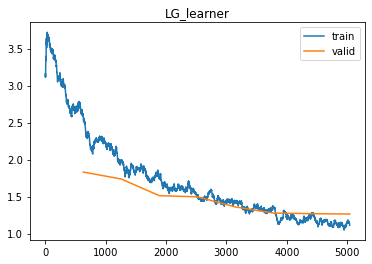

In [12]:
for learner, name in zip(learners, learner_names):
    learner.recorder.plot_loss()
    plt.title(name)
    plt.show()